In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
import sys

plt.style.use('seaborn')
%matplotlib inline

# Load snapshot data
# df = pd.read_csv(r'Snapshot CSVs/All_Snapshots.csv')

In [293]:
up_df = pd.read_csv(r'Snapshot CSVs/Up_Snapshot.csv')
peak_df = pd.read_csv(r'Snapshot CSVs/Peak_Snapshot.csv')
rim_df = pd.read_csv(r'Snapshot CSVs/Rim_Snapshot.csv')
fall_df = pd.read_csv(r'Snapshot CSVs/Fall_Snapshot.csv')

def dropAllDuplicates(df):
    duplicates = df.drop(['EVENT_NUM', 'SHOOTER_ID', 'SHOT_DISTANCE', 'SHOT_TIME',
                          'OFFENSIVE_REB', 'EVENT_TIME'], axis=1).duplicated(keep=False)
    return df[~duplicates]

up_df = dropAllDuplicates(up_df)
peak_df = dropAllDuplicates(peak_df)
rim_df = dropAllDuplicates(rim_df)
fall_df = dropAllDuplicates(fall_df)

In [294]:
def flipCourt(df):
    xlocs = [col for col in df.columns if ('XLOC' in col) and ('PLAYER' in col)]
    ylocs = [col for col in df.columns if ('YLOC' in col) and ('PLAYER' in col)]
    xvels = [col for col in df.columns if 'XVEL' in col]
    yvels = [col for col in df.columns if 'YVEL' in col]
    
    for i in range(0, len(xlocs)):
        df[xlocs[i]] = np.where(rim_df['BALL_XLOC'] > 47,
                                94 - df[xlocs[i]],
                                df[xlocs[i]])
        df[ylocs[i]] = np.where(rim_df['BALL_XLOC'] > 47,
                                50 - df[ylocs[i]],
                                df[ylocs[i]])
        df[xvels[i]] = np.where(rim_df['BALL_XLOC'] > 47,
                                -1 * df[xvels[i]],
                                df[xvels[i]])
        df[yvels[i]] = np.where(rim_df['BALL_XLOC'] > 47,
                                -1 * df[yvels[i]],
                                df[yvels[i]])
    df['BALL_DISTRIM'] = np.where(rim_df['BALL_XLOC'] > 47,
                                 df['BALL_DIST_RIM2'],
                                 df['BALL_DIST_RIM1'])
    df['BALL_YLOC'] = np.where(rim_df['BALL_XLOC'] > 47,
                                50 - df['BALL_YLOC'],
                                df['BALL_YLOC'])
    df['BALL_XLOC'] = np.where(rim_df['BALL_XLOC'] > 47,
                                94 - df['BALL_XLOC'],
                                df['BALL_XLOC'])
    
    return df

up_df = flipCourt(up_df)
peak_df = flipCourt(peak_df)
fall_df = flipCourt(fall_df)
rim_df = flipCourt(rim_df)

for i in range(1, 11):
    col = 'PLAYER{}_{}'
    xloc = up_df[col.format(i, 'XLOC')]
    yloc = up_df[col.format(i, 'YLOC')]
    up_df[col.format(i, 'DISTRIM')] = ((xloc-5.25)**2 + (yloc-25)**2)**.5

In [295]:
# Remove non-shots. These are plays that descend to 11 feet farther than 5 feet away
goodrows = ((rim_df['BALL_DIST_RIM1'] < 5) | (rim_df['BALL_DIST_RIM2'] < 5))

up_df = up_df[goodrows]
peak_df = peak_df[goodrows]
rim_df = rim_df[goodrows]
fall_df = fall_df[goodrows]

# Shots outside of 30 feet and rebounds over 20
badrows = ((up_df['BALL_DISTRIM'] > 30) | (fall_df['BALL_DISTRIM'] > 25))

up_df = up_df[~badrows]
peak_df = peak_df[~badrows]
rim_df = rim_df[~badrows]
fall_df = fall_df[~badrows]

In [296]:
teamlist = list(up_df['PLAYER1_TEAMID'].unique())
up_df = up_df[~up_df['REBOUNDER_ID'].isin(teamlist)]
peak_df = peak_df[~peak_df['REBOUNDER_ID'].isin(teamlist)]
rim_df = rim_df[~rim_df['REBOUNDER_ID'].isin(teamlist)]
fall_df = fall_df[~fall_df['REBOUNDER_ID'].isin(teamlist)]

In [297]:
xloc = 'PLAYER{}_{}'
yloc = 'PLAYER{}_{}'
for i in range(1,11):
    xshift = up_df[xloc.format(i,'XLOC')] - 5.25
    yshift = up_df[yloc.format(i,'YLOC')] - 25
    theta = np.arctan2(yshift, xshift)
    
    newx = xshift*np.cos(theta) + yshift*np.sin(theta)
    newy = -xshift*np.sin(theta) + yshift*np.cos(theta)
    
    up_df[xloc.format(i,'BOXEDOUT')] = False
    
    for j in range(1,11):
        if i != j:
            pxshift = up_df[xloc.format(j,'XLOC')] - 5.25
            pyshift = up_df[yloc.format(j,'YLOC')] - 25
            
            px = pxshift*np.cos(theta) + pyshift*np.sin(theta)
            py = -pxshift*np.sin(theta) + pyshift*np.cos(theta)
            
            up_df[xloc.format(i,'BOXEDOUT')] = (up_df[xloc.format(i,'BOXEDOUT')] |
                                                ((0 < newx - px) &
                                                (newx > newx - px) &
                                                (np.fabs(py) < np.fabs(px/2)) &
                                                (np.fabs(py) < 2)) &
                                                (np.fabs((newx-px)) > np.fabs(py)))

Rebounder: PLAYER8_
PLAYER1_BOXEDOUT      True
PLAYER2_BOXEDOUT      True
PLAYER3_BOXEDOUT      True
PLAYER4_BOXEDOUT      True
PLAYER5_BOXEDOUT     False
PLAYER6_BOXEDOUT     False
PLAYER7_BOXEDOUT      True
PLAYER8_BOXEDOUT     False
PLAYER9_BOXEDOUT     False
PLAYER10_BOXEDOUT     True
Name: 119, dtype: object


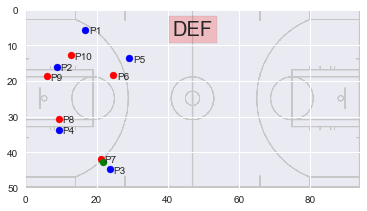

In [250]:
def plotPlay(df, i, suf):
    court = plt.imread("fullcourt.png")
    plt.imshow(court, zorder = 0, extent=[0,94,50,0])
    col = 'PLAYER{}_{}LOC'
    row = df.iloc[i]
    
    for j in range(1,11):
        x = col.format(j, 'X')
        y = col.format(j, 'Y')
        if j <= 5:
            c = 'blue'
        else:
            c = 'red'
        plt.scatter(row[x], row[y], c = c)
        plt.text(row[x]+1, row[y]+1, 'P'+str(j))

    plt.scatter(row['BALL_XLOC'], row['BALL_YLOC'], c = 'green')
#     plt.scatter(row['BALL_XLOC_FALL'], row['BALL_YLOC_FALL'], c = 'green')
    
#     plt.text(row['PLAYER1_XLOC'+suf], row['PLAYER1_YLOC'+suf], 'P1')
    
    if row['OFFENSIVE_REB'] == 1:
        txt = 'OFF'
        col = 'blue'
    else:
        txt = 'DEF'
        col = 'red'
    plt.text(47, 7, txt, fontsize=20, horizontalalignment='center',
             bbox=dict(facecolor=col, alpha=0.2))
    
n = 103

id_cols = [col for col in up_df.columns if '_ID' in col]
b = (up_df.iloc[n][id_cols] == up_df.iloc[n]['REBOUNDER_ID'])
print('Rebounder: {}'.format(b[b==True].index[0][:-2]))

box_cols = [col for col in up_df.columns if 'BOXEDOUT' in col]
print(up_df.iloc[n][box_cols])

plotPlay(up_df, n, '_FALL')

In [312]:
dist_cols = [col for col in up_df.columns if ('DISTRIM' in col) and ('PLAYER' in col)]
box_cols = [col for col in up_df.columns if 'BOXEDOUT' in col]
vel_cols = [col for col in up_df.columns if ('VEL' in col) and ('PLAYER' in col)]

data = up_df[dist_cols+box_cols+vel_cols].copy()
data['BALL_DISTRIM_UP'] = up_df['BALL_DISTRIM']
data['BALL_DISTRIM_FALL'] = fall_df['BALL_DISTRIM']


In [283]:
from sklearn import linear_model

def rebLength(X):
    tempX = X['BALL_DISTRIM_UP'].values.reshape(-1,1)
    tempy = X['BALL_DISTRIM_FALL']
    model = linear_model.LinearRegression()
    model.fit(tempX, tempy)
    y_pred = model.predict(tempX)
    return y_pred

In [131]:
def orderRows(row):
    sortcols = ['Off_Dist1', 'Off_Dist2', 'Off_Dist3', 'Off_Dist4', 'Off_Dist5',
               'Def_Dist1', 'Def_Dist2', 'Def_Dist3', 'Def_Dist4', 'Def_Dist5'
               ]
    id_to_idx = dict(zip(row['PLAYER_IDS'].split(), row.index))

    return row[sortcols].sort_values().index.get_loc(id_to_idx[row['Rebounder_ID']])
    
outdf['Player_Num'] = outdf.apply(orderRows, axis = 1)

def sortByClosest(df):
    in_cols = ['Off_Dist1', 'Off_Dist2', 'Off_Dist3', 'Off_Dist4', 'Off_Dist5',
               'Def_Dist1', 'Def_Dist2', 'Def_Dist3', 'Def_Dist4', 'Def_Dist5'
               ]
    
    vals = df[in_cols].values
    vals.sort(axis=1)
    df[in_cols] = vals
    

outdf.drop(['PLAYER_IDS', 'Rebounder_ID'], axis = 1, inplace = True)
sortByClosest(outdf)

In [134]:
import time
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import GridSearchCV

X = outdf.drop('Player_Num', axis = 1)
y = outdf['Player_Num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
t0 = time.time()
# No data split
model = KNN(n_neighbors=3)
model.fit(X_train, y_train)
predicted = model.predict(X_test)
# print(metrics.precision_score(y_test, predicted))
# print(metrics.recall_score(y_test, predicted))
print(metrics.confusion_matrix(y_test, predicted))
t1 = time.time()
print (t1 - t0)

[[3140  126   41   17    9    4    2    0    0    0]
 [ 442   34   10    4    3    0    0    0    0    0]
 [ 247   23    6    4    1    1    0    0    0    0]
 [ 136   13    6    1    2    2    1    0    0    0]
 [ 103    4    6    3    2    3    0    0    0    0]
 [  82    6    3    3    3    0    1    0    0    0]
 [  49    7    3    1    1    2    2    1    0    0]
 [  30    3    1    0    1    0    1    0    0    0]
 [  20    1    0    0    0    0    1    0    0    0]
 [  17    2    1    0    0    0    0    0    0    0]]
0.22101283073425293


In [45]:
parameters = {'n_neighbors': range(1,100)}
knn = KNN()
knnmodel = GridSearchCV(knn, parameters)
knnmodel.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': range(1, 100)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [4]:
# pd.DataFrame(list(zip(X.columns, [x[0] for x in np.transpose(model.coef_)])))

In [25]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model2 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                    max_depth=1, random_state=0)
model2.fit(X_train, y_train)
predicted = model2.predict(X_test)
print(metrics.confusion_matrix(y_test, predicted))

[[4037   23]
 [ 846   13]]


In [20]:
# Cross-validation
t0 = time.time()
scores = cross_val_score(KNN(n_neighbors=30), X, y, scoring='accuracy', cv=10)
print(scores.mean())
t1 = time.time()
print(t1 - t0)

0.823604839602
4.147237062454224


In [39]:
from imblearn.over_sampling import RandomOverSampler

X = outdf.drop('Off_Reb', axis = 1)
y = outdf['Off_Reb']

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X, y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, random_state=0)
model2 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                    max_depth=1, random_state=0)
model2.fit(X_train, y_train)
predicted = model2.predict(X_test)
print(model2.score(X_test, y_test))
print(metrics.confusion_matrix(y_test, predicted))

0.862980280545
[[3888  172]
 [ 502  357]]


In [32]:
# Cross-validation
t0 = time.time()
scores = cross_val_score(GradientBoostingClassifier(n_estimators=100,
                                                    learning_rate=1.0,
                                                    max_depth=1,
                                                    random_state=0),
                         X_resampled, y_resampled, scoring='accuracy', cv=10)
print(scores.mean())
t1 = time.time()
print(t1 - t0)

0.599900211092
8.290473937988281
